## One-Machine Infinite-Bus System (OMIB or SMIB)

The following notebook provides an example to construct a differential-algebraic equation system of a 2-state synchronous machine model connected via a transmission line to an infinite bus.

<img src="https://d3i71xaburhd42.cloudfront.net/2aae52e6566fd8ab651674d4d48f777a43aad9c7/1-Figure1-1.png" width=30% />

The two-state machine model has a fixed internal voltage $E_q'$ and a differential equation model for the rotor angle and speed:
$$
\begin{align}
\dot{\delta} &= \Omega_b (\omega - 1.0) \\
\dot{\omega} &= \frac{1}{2H}(p_m - p_e - D(\omega - 1.0))
\end{align}
$$
on which $\omega$ is the rotor speed in per unit, $H$ is the machine inertia (typically 4-8 seconds) and $D$ is the synchronizing damping (typically 1 - 2 per unit). We assume that the mechanical fixed is fixed.

Consider that the generator has an internal reactance given by $X_q$. We ignore the line and generator resistance $R_l = R_a = 0$, and hence the equivalent reactance is given by $X_e = X_q + X_l$. THen if the infinite bus voltage is given by $V_\infty = V\angle 0$ our electrical torque is simply:
$$ p_e = \frac{E_q' V}{X_e} \sin \delta $$

differential system is simply:
$$
\dot{x} = \left[\begin{array}{c} \dot{\delta} \\ \dot{\omega} \end{array} \right] = \left[\begin{array}{c} \Omega_b (\omega - 1.0)  \\ \frac{1}{2H}\left(p_m - \frac{E_q' V}{X_e} \sin \delta - D(\omega - 1.0)\right) \end{array} \right]
$$

To solve this problem we will use DifferentialEquations.jl package. You can check the documentation [here](https://diffeq.sciml.ai/stable/)

In [191]:
using DifferentialEquations
using NLsolve
using Plots
using Sundials

First, we construct the function as follows:

In [90]:
function ODE_OMIB(dx, x, p, t)
    #Obtain States
    δ = x[1]
    ω = x[2]
    #Obtain parameters
    Eq = p[1]
    Xq = p[2]
    Xl = p[3]
    H = p[4]
    D = p[5]
    V = p[6]
    pm = p[7]
    Ωb = p[8]
    
    #Compute additional parameters
    Xeq = Xq + Xl
    pe = Eq*V/Xeq * sin(δ)
    
    #Compute ODE
    dx[1] = Ωb * (ω - 1.0)
    dx[2] = (1.0 / (2 * H)) * (pm - pe - D * (ω - 1.0))
end 

ODE_OMIB (generic function with 2 methods)

Now we set-up some parameters to be used in our simulation:

In [91]:
p0 = [
    0.9 #Eq
    0.25 #Xq
    0.1 #Xl
    5.0 #H
    2.0 #D
    1.0 #V
    0.5 #pm
    2*pi*50.0 # Ωb
]

8-element Array{Float64,1}:
   0.9
   0.25
   0.1
   5.0
   2.0
   1.0
   0.5
 314.1592653589793

Now we can construct an auxiliary function to compute the initial states using a nonlinear solver of the form:
$$f(x) = 0$$
then `nlsolve(f, initial_guess)` finds the root `x0`.

In [92]:
# Auxiliary function replacing the parameters and t = 0.0
f = (dx, x) -> ODE_OMIB(dx, x, p0, 0.0) 

#21 (generic function with 1 method)

In [93]:
initial_guess = [0.0; 0.0]
#Find the initial solution
init_sol = nlsolve(f, initial_guess, ftol = 1e-10)

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.0, 0.0]
 * Zero: [0.19569105286523947, 1.0]
 * Inf-norm of residuals: 0.000000
 * Iterations: 12
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-10: true
 * Function Calls (f): 13
 * Jacobian Calls (df/dx): 13

In [94]:
x0_init = init_sol.zero

2-element Array{Float64,1}:
 0.19569105286523947
 1.0

Now that we have our initial condition, we can construct our differential equation:

In [95]:
#time span:
tspan = (0.0, 60.0)
#Construc ODE Problem
prob = ODEProblem(
        ODE_OMIB, #function
        x0_init, #initial_guess
        tspan, #time span
        p0, #parameters
)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 60.0)
u0: [0.19569105286523947, 1.0]

In [96]:
#Solve optimization problem
ODE_solution = solve(prob, Tsit5(), dtmax = 0.02)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 3004-element Array{Float64,1}:
  0.0
  9.999999999999999e-5
  0.0010999999999999998
  0.011099999999999997
  0.031099999999999996
  0.05109999999999999
  0.0711
  0.0911
  0.1111
  0.1311
  0.15109999999999998
  0.17109999999999997
  0.19109999999999996
  ⋮
 59.79110000000375
 59.811100000003755
 59.83110000000376
 59.85110000000376
 59.871100000003764
 59.89110000000377
 59.91110000000377
 59.931100000003774
 59.95110000000378
 59.97110000000378
 59.99110000000378
 60.0
u: 3004-element Array{Array{Float64,1},1}:
 [0.19569105286523947, 1.0]
 [0.19569105286523947, 1.0]
 [0.19569105286523947, 1.0]
 [0.19569105286523947, 1.0]
 [0.19569105286523947, 1.0]
 [0.19569105286523947, 1.0]
 [0.19569105286523947, 1.0]
 [0.19569105286523947, 1.0]
 [0.19569105286523947, 1.0]
 [0.19569105286523947, 1.0]
 [0.19569105286523947, 1.0]
 [0.19569105286523947, 1.0]
 [0.19569105286523947, 1.0]
 ⋮
 [0.19569105286523947, 1.0]
 [0.1956

In [97]:
# Obtain time
t = ODE_solution.t
#Obtain first state: δ
δ_sol = [x[1] for x in ODE_solution.u];

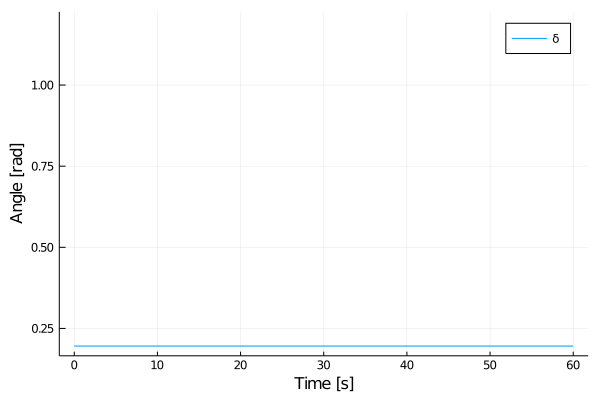

In [98]:
plot(t, δ_sol, xlabel = "Time [s]", ylabel = "Angle [rad]", label = "δ")

Now, this is a quite boring result... We knew that the solution satisfied $\dot{x} = 0$, so the system stays still and does not move. But, let's now try a fault!
A really cool property of DifferentialEquations.jl is that you can create a Callback. This will stop the solver, do something that you want, and then continue solving.

A discrete callback is constructed using what is called a `condition`, that when that is true, it will apply the `affect`. We will apply a fault at time `t = 1.0`, that disconnects a circuit of the transmission line, duplicating `Xl`. 

In [99]:
#Our condition occurs when t == 1.0
condition(u,t,integrator) = t==1.0
#Our affect says that our parameter 3, that is the reactance of the line, doubles.
affect!(integrator) = integrator.p[3] = integrator.p[3] * 2
#Construct the callback
cb = DiscreteCallback(condition,affect!)

DiscreteCallback{typeof(condition),typeof(affect!),typeof(DiffEqBase.INITIALIZE_DEFAULT)}(condition, affect!, DiffEqBase.INITIALIZE_DEFAULT, Bool[1, 1])

In [100]:
ODE_solution_fault = solve(
    prob, #ODEProblem created
    Tsit5(), #Solver
    dtmax = 0.02, #Maximum time step allowed
    callback=cb, #Callback created
    tstops = [1.0] #Force the solution to stop at t=1.0
)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 3005-element Array{Float64,1}:
  0.0
  9.999999999999999e-5
  0.0010999999999999998
  0.011099999999999997
  0.031099999999999996
  0.05109999999999999
  0.0711
  0.0911
  0.1111
  0.1311
  0.15109999999999998
  0.17109999999999997
  0.19109999999999996
  ⋮
 59.780000000003746
 59.80000000000375
 59.82000000000375
 59.840000000003755
 59.86000000000376
 59.88000000000376
 59.900000000003764
 59.92000000000377
 59.94000000000377
 59.960000000003774
 59.98000000000378
 60.0
u: 3005-element Array{Array{Float64,1},1}:
 [0.19569105286523947, 1.0]
 [0.19569105286523947, 1.0]
 [0.19569105286523947, 1.0]
 [0.19569105286523947, 1.0]
 [0.19569105286523947, 1.0]
 [0.19569105286523947, 1.0]
 [0.19569105286523947, 1.0]
 [0.19569105286523947, 1.0]
 [0.19569105286523947, 1.0]
 [0.19569105286523947, 1.0]
 [0.19569105286523947, 1.0]
 [0.19569105286523947, 1.0]
 [0.19569105286523947, 1.0]
 ⋮
 [0.25252565973591795, 0.9999990273

In [101]:
# Obtain time
t = ODE_solution_fault.t
#Obtain first state: δ
δ_sol = [x[1] for x in ODE_solution_fault.u];

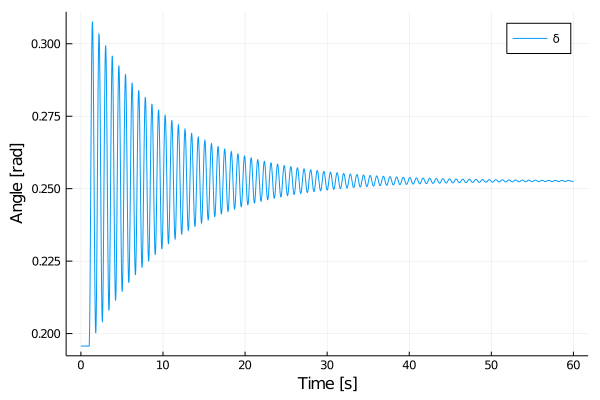

In [103]:
plot(t, δ_sol, xlabel = "Time [s]", ylabel = "Angle [rad]", label = "δ")

As we can see the fault makes the angle to go to an additional equilibrium, with an increased angle, that showcases that now the machine is providing more electrical power to the infinite bus.

## Modeling algebraic equations

Now we want to go to a more general form, that allow us to model directly algebraic equation with additional states if we are interested. We will model the same system, but now we will consider the magnitude and angle of the voltage that the generator is connected (i.e. the voltage between $X_q$ and $X_l$.)

With this, we model the angle that the generator is connected as $V_1\angle \theta_1$ and the infinite bus is $V_0\angle \theta_0$. The voltage and angle of the infinite bus is fixed.

For a general modeling we require to define two rotating reference. The standard real-imaginary frame uses to model the bus voltages is the one we are used to. The generator rotating reference frame $dq$ requires to transform our voltage as bus 1 to their reference frame using a Park transformation as follows:
$$ v_d = v_1 \sin(\delta - \theta_1) \\
v_q = v_1 \cos(\delta - \theta_1)
$$

Then our states will be:
$$\delta, \omega, p_e, v_1, \theta_1$$
and our equations will be:
Machine states:
$$
\begin{align*}
\dot{\delta} &= \Omega_b (\omega - 1.0) \\
\dot{\omega} &= \frac{1}{2H} (p_m - p_e - D(\omega - 1.0)) 
\end{align*}
$$
Machine algebraic equations: Power, Ohm's Law and Voltage transformation:
$$
\begin{align*}
p_e &= (v_d + R_a i_d) i_d + (v_q + R_a i_q) i_q \\
e_q' - v_q &= R_a i_q + X_qi_d \\
0 - v_d &= R_a i_d - X_q i_q \\
v_d &= V_1 \sin(\delta - \theta_1) \\
v_q &= V_1 \cos(\delta - \theta_1) 
\end{align*}
$$
and power flow through lines:
$$
\begin{align*}
v_di_d + v_qi_q &= \frac{V_1V_0}{X_l}\sin(\theta_1 - \theta_0) \\
v_qi_d  - v_d i_q &= \frac{V_1^2}{X_l} - \frac{V_1V_0}{X_l}\cos(\theta_1 - \theta_0)
\end{align*}
$$

With $Ra = 0$, we construct our equations as follow:

In [272]:
function DAE_OMIB_extended(out, dx, x, p, t)
    #Obtain States
    δ = x[1]
    ω = x[2]
    pe = x[3]
    V1 = x[4]
    θ1 = x[5]
    #Obtain parameters
    Eq = p[1]
    Xq = p[2]
    Xl = p[3]
    H = p[4]
    D = p[5]
    V0 = p[6]
    θ0 = p[7]
    pm = p[8]
    Ωb = p[9]
    
    #Compute aditional variables
    vd = V1 * sin(δ - θ1)
    vq = V1 * cos(δ - θ1)
    id = (1.0 / Xq) * (Eq - vq)
    iq = (1.0 / Xq) * vd
    
    #Compute ODE
    out[1] = Ωb * (ω - 1.0) - dx[1]
    out[2] = (1.0 / (2 * H)) * (pm - pe - D * (ω - 1.0)) - dx[2]
    
    #Compute algebraic equations
    out[3] = vd * id + vq * iq - pe
    #Power Flow through lines
    out[4] = vd * id + vq * iq - (V1 * V0 / Xl) * sin(θ1 - θ0)
    out[5] = vq * id - vd * iq - V1^2/Xl + (V1 * V0 / Xl) * cos(θ1 - θ0)
end 

DAE_OMIB_extended (generic function with 1 method)

In [273]:
tspan = (0.0, 60.0)
p0_extended = [
    0.9 #Eq
    0.25 #Xq
    0.1 #Xl
    5.0 #H
    2.0 #D
    1.0 #V0
    0.0 #θ0
    0.5 #pm
    2*pi*50.0 # Ωb
]

9-element Array{Float64,1}:
   0.9
   0.25
   0.1
   5.0
   2.0
   1.0
   0.0
   0.5
 314.1592653589793

In [274]:
# Auxiliary function replacing the parameters and t = 0.0
f_extended = (out, x) -> DAE_OMIB_extended(out, zeros(5), x, p0_extended, 0.0) 

#63 (generic function with 1 method)

In [275]:
initial_guess = zeros(5)
sol_extended = nlsolve(f_extended, initial_guess, ftol=1e-10)

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.0, 0.0, 0.0, 0.0, 0.0]
 * Zero: [0.0, 1.0000001003169507, 0.004950493063007488, 0.0, 0.0]
 * Inf-norm of residuals: 0.049505
 * Iterations: 1000
 * Convergence: false
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-10: false
 * Function Calls (f): 12
 * Jacobian Calls (df/dx): 10

In [276]:
# It doesn't look quite right... We need a better initial guess
initial_guess = [
    0.2, #δ
    1.0, #ω
    0.5, #pe
    1.0, #V1
    0.0, #θ1
]
sol_extended = nlsolve(f_extended, initial_guess, ftol=1e-10)

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.2, 1.0, 0.5, 1.0, 0.0]
 * Zero: [0.1956910528652395, 1.0, 0.5, 0.9678130573302733, 0.05168587929149758]
 * Inf-norm of residuals: 0.000000
 * Iterations: 4
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-10: true
 * Function Calls (f): 5
 * Jacobian Calls (df/dx): 5

In [277]:
x0_init = sol_extended.zero

5-element Array{Float64,1}:
 0.1956910528652395
 1.0
 0.5
 0.9678130573302733
 0.05168587929149758

Now we need to handle that the last 3 equations are not differential equations, but indeed algebraic. To do so, we identify with trues and falses which ones are differential:

In [278]:
differential_vars = [true, true, false, false, false]

5-element Array{Bool,1}:
 1
 1
 0
 0
 0

In [279]:
prob_extended = DAEProblem(
    DAE_OMIB_extended,
    zeros(5), #xdot(0) = 0.0
    x0_init,
    tspan,
    p0_extended;
    differential_vars = differential_vars)

DAEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 60.0)
u0: [0.1956910528652395, 1.0, 0.5, 0.9678130573302733, 0.05168587929149758]
du0: [0.0, 0.0, 0.0, 0.0, 0.0]

In [280]:
ODE_sol_extended = solve(prob_extended, IDA(), dtmax=0.02 )

retcode: Success
Interpolation: 3rd order Hermite
t: 3001-element Array{Float64,1}:
  0.0
  0.02
  0.04
  0.06
  0.08
  0.1
  0.12000000000000001
  0.14
  0.16
  0.18
  0.19999999999999998
  0.21999999999999997
  0.23999999999999996
  ⋮
 59.780000000003746
 59.80000000000375
 59.82000000000375
 59.840000000003755
 59.86000000000376
 59.88000000000376
 59.900000000003764
 59.92000000000377
 59.94000000000377
 59.960000000003774
 59.98000000000378
 60.0
u: 3001-element Array{Array{Float64,1},1}:
 [0.1956910528652395, 1.0, 0.5, 0.9678130573302733, 0.05168587929149758]
 [0.1956910528652395, 1.0, 0.5000000000000001, 0.9678130573302733, 0.0516858792914976]
 [0.1956910528652395, 1.0, 0.5000000000000002, 0.9678130573302733, 0.05168587929149761]
 [0.1956910528652395, 1.0, 0.5000000000000002, 0.9678130573302733, 0.05168587929149761]
 [0.1956910528652395, 1.0, 0.5000000000000002, 0.9678130573302733, 0.0516858792914976]
 [0.1956910528652395, 1.0, 0.5000000000000001, 0.9678130573302733, 0.051685879

In [281]:
plot(ODE_sol_extended)

As we can see the five states, stay fixed, showcasing indeed an stable point. Now we introduce again the same callback, that modifies the line parameter

In [282]:
DAE_sol_extended = solve(prob_extended, IDA(), callback=cb, tstops=[1.0], dtmax=0.02)

retcode: Success
Interpolation: 3rd order Hermite
t: 3010-element Array{Float64,1}:
  0.0
  0.001
  0.002
  0.004
  0.008
  0.016
  0.032
  0.052000000000000005
  0.07200000000000001
  0.09200000000000001
  0.11200000000000002
  0.132
  0.152
  ⋮
 59.79028401056264
 59.81028401056264
 59.83028401056264
 59.850284010562646
 59.87028401056265
 59.89028401056265
 59.910284010562656
 59.93028401056266
 59.95028401056266
 59.970284010562665
 59.99028401056267
 60.0
u: 3010-element Array{Array{Float64,1},1}:
 [0.1956910528652395, 1.0, 0.5, 0.9678130573302733, 0.05168587929149758]
 [0.1956910528652395, 1.0, 0.5000000000000001, 0.9678130573302733, 0.0516858792914976]
 [0.1956910528652395, 1.0, 0.5000000000000002, 0.9678130573302733, 0.05168587929149761]
 [0.1956910528652395, 1.0, 0.5000000000000001, 0.9678130573302733, 0.0516858792914976]
 [0.1956910528652395, 1.0, 0.5000000000000001, 0.9678130573302733, 0.051685879291497594]
 [0.1956910528652395, 1.0, 0.5000000000000002, 0.9678130573302733, 0

In [283]:
# Obtain time
t = DAE_sol_extended.t
#Obtain first state: δ
δ_sol = [x[1] for x in DAE_sol_extended.u];

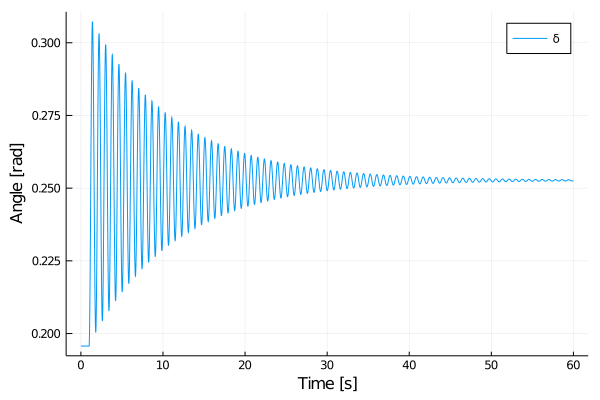

In [284]:
plot(t, δ_sol, xlabel = "Time [s]", ylabel = "Angle [rad]", label = "δ")

Now we can plot our voltage at bus 1 (i.e. state 4):

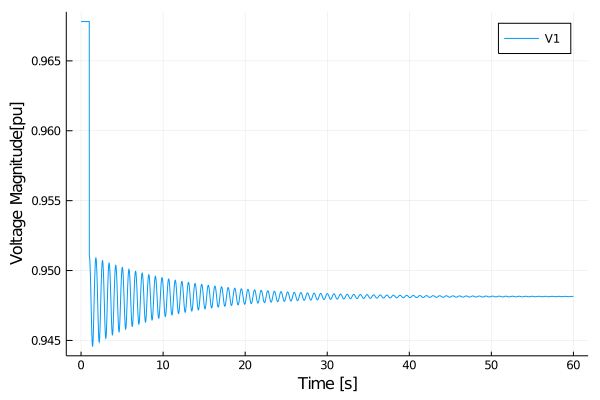

In [286]:
# Obtain time
t = DAE_sol_extended.t
#Obtain first state: δ
v_sol = [x[4] for x in DAE_sol_extended.u];
plot(t, v_sol, xlabel = "Time [s]", ylabel = "Voltage Magnitude [pu]", label = "V1")